In [1]:
import numpy as np
import pickle
import sklearn.decomposition
import sklearn.manifold
import sklearn.linear_model
import matplotlib.pyplot as plt



<b>Import data: </b>

In [3]:
pkl_filename = "features_labels.pkl"
features_labels = pickle.load(open(pkl_filename, 'rb'))

features = features_labels[:,:4096] #everything but last column
labels = features_labels[:,4096]

<b>Separate training and test data:</b>

In [6]:
num_samples = features.shape[0]

test_idx = np.random.choice(range(num_samples), int(num_samples/5), replace=False) #take 1/5th of data for test data
test_features = features[test_idx]
test_labels = labels[test_idx]

train_idx = [i for i in range(num_samples) if i not in test_idx]
train_features = features[train_idx]
train_labels = labels[train_idx]

print ('testing samples: ',test_features.shape)
print ('training samples: ',train_features.shape)


testing samples:  (4390, 4096)
training samples:  (17562, 4096)


<b>Dimensionality reduction using Principal Component Analysis</b>

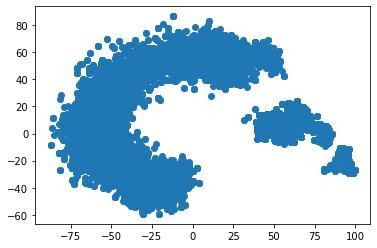

In [17]:
PCA_2d = sklearn.decomposition.PCA(n_components=2).fit_transform(features) #only using PCA for the TSNE visualization
plt.scatter(PCA_2d[:,0], PCA_2d[:,1])

<b>Visualizations using t-distributed stochastic neighbor embedding (TSNE)</b>

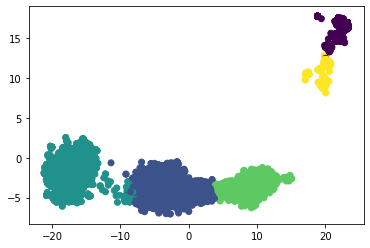

In [21]:
n = 100 #can adjust this to improve visualization
PCA_reduced = sklearn.decomposition.PCA(n_components=n).fit_transform(test_features) #reduced dimensionality for TSNE

TSNE_embed = sklearn.manifold.TSNE(n_components=2, perplexity=300).fit_transform(PCA_reduced) #adjusting perplexity also can improve the visualization
plt.scatter(TSNE_embed[:,0], TSNE_embed[:,1], c=test_labels)


<b>Multi Dimensional Scaling (MDS) - wants to keep distances the same in new Low-D space</b>

In [ ]:
#I haven't been able to get this way to visualize to work, but I don't think we need it if we do the TSNE

#n = 10
#PCA_reduced = sklearn.decomposition.PCA(n_components=n).fit_transform(test_features) #reduced dimensionality for computational reasons

#MDS_embed = sklearn.manifold.MDS(n_components=2).fit_transform(PCA_reduced)
#plt.scatter(MDS_embed[:,0], Mds_embed[:,1], c=test_labels)

<b>Logistic regression on all features to determine best coefficients:</b>

In [16]:
X = features
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

log_reg2 = sklearn.linear_model.LogisticRegressionCV(cv=5, Cs=[0.01, 0.1, 1, 10],
                                                    max_iter=5000,
                                                    penalty='l2', solver='liblinear',
                                                    multi_class='ovr')

log_reg2.fit(X_train,y_train) #this needs to be on a subset of new data for correct scores, here we use the test data

log_reg2_training_validation_score = log_reg2.score(X_train,y_train) #getting the cross validation score

print('Training validation score')
print(log_reg2_training_validation_score)

log_reg2_training_validation_score = log_reg2.score(X_test, y_test) #getting the cross validation score

print('Testing validation score')
print(log_reg2_training_validation_score)


Training validation score
0.9999320051676073
Testing validation score
0.9972394755003451


In [ ]:

log_reg = sklearn.linear_model.LogisticRegressionCV(cv=5, Cs=[0.01, 0.1, 1, 10], #trying to fine tune regularization parameter
                                                    max_iter=5000,
                                                    penalty='l2', solver='liblinear',
                                                    multi_class='ovr')

log_reg.fit(train_features, train_labels) #fitting logistic regression model to the training data
# log_reg_valid_scores = log_reg.scores_
log_reg_valid_score = log_reg.score(train_features, train_labels)

print(log_reg_valid_score) #this will always be 1 since we are validating on the same data that we trained on

<b>Choosing features based on best logistic regression coefficients:</b>

In [8]:
CV_coefficients = log_reg.coef_ #finding coefficients of the logistic regression equation (there will be a column of coeff for each feature fot each class, so a 5x4096 matrix)
Sum_coef = np.sum(np.abs(CV_coefficients), axis=0) #summing the coeff by class to get 1x4096 
Num_features = 20 #can change this to increase accuracy 
Lgst_coef_idx = Sum_coef.argsort()[-Num_features:] #select n features with largest overall coefficients 

<b>Now that we have our largest coefficients, we retry a regression model on test data</b>

In [14]:
from sklearn.model_selection import train_test_split
X = test_features[:,Lgst_coef_idx]
y = test_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

log_reg2 = sklearn.linear_model.LogisticRegressionCV(cv=5, Cs=[0.01, 0.1, 1, 10],
                                                    max_iter=5000,
                                                    penalty='l2', solver='liblinear',
                                                    multi_class='ovr')

log_reg2.fit(X_train,y_train) #this needs to be on a subset of new data for correct scores, here we use the test data

log_reg2_training_validation_score = log_reg2.score(X_train,y_train) #getting the cross validation score

print('Training validation score')
print(log_reg2_training_validation_score)

log_reg2_training_validation_score = log_reg2.score(X_test, y_test) #getting the cross validation score

print('Testing validation score')
print(log_reg2_training_validation_score)

Training validation score
0.9945596735804149
Testing validation score
0.9875776397515528
